# importing and exploaring the dataset

In [1]:
!kaggle datasets download -d thomasdubail/brain-tumors-256x256

Dataset URL: https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256
License(s): CC0-1.0
 81% 48.0M/59.4M [00:00<00:00, 254MB/s]
100% 59.4M/59.4M [00:00<00:00, 251MB/s]


In [2]:
import zipfile

# Corrected code
with zipfile.ZipFile('/content/brain-tumors-256x256.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [3]:
# checking the number od channels in an images
from PIL import Image
# Load a sample image
image_path = '/content/sample_data/Data/glioma_tumor/G_1.jpg'
image = Image.open(image_path)

# Check the mode of the image
mode = image.mode

# Determine the number of channels
if mode == 'RGB':
    num_channels = 3
elif mode == 'L':
    num_channels = 1
elif mode == 'RGBA':
    num_channels = 4
else:
    num_channels = None

print(f"The image mode is {mode} which indicates {num_channels} channels.")


The image mode is RGB which indicates 3 channels.


## Creating a Dataloader

In [4]:
# creating a dataset
import torchvision
from torchvision import datasets

In [5]:
import os
dir_1=len(os.listdir('/content/sample_data/Data/glioma_tumor'))
dir_2=len(os.listdir('/content/sample_data/Data/meningioma_tumor'))
dir_3=len(os.listdir('/content/sample_data/Data/normal'))
dir_4=len(os.listdir('/content/sample_data/Data/pituitary_tumor'))
print(f'we have {dir_1} glioma_tumor images.')
print(f'we have {dir_2} menlingioma_tumor images.')
print(f'we have {dir_3} normal/No tumor images.')
print(f'we have {dir_4} pitiuitary_tumor images.')

we have 901 glioma_tumor images.
we have 913 menlingioma_tumor images.
we have 438 normal/No tumor images.
we have 844 pitiuitary_tumor images.


+ As we can see we have class imbalance so to overcome this we will do data augmentation on normal images.

### Data augmentation

In [6]:
# number of augmentation required in each class
target_count=1000

original_counts={
    'glioma_tumor':901,
    'meningoma_tumor':913,
    'normal':438,
    'pituitary_tumor':844
}

augmentation_counts={key:target_count - count for key,count in original_counts.items()}
print(augmentation_counts)

{'glioma_tumor': 99, 'meningoma_tumor': 87, 'normal': 562, 'pituitary_tumor': 156}


In [7]:
import os
import random
from PIL import Image
from torchvision import transforms
import torch

# creating a function for data augmentation
def data_augmentation(input_folder,tranform_list, output_folder,num_images):
  tranform=transforms.Compose([transforms.ToTensor(),random.choice(tranform_list)])

  image_files= [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
  image_count=0
  while image_count<num_images:
    img_file=random.choice(image_files)
    img_path=os.path.join(input_folder,img_file)

    img=Image.open(img_path)

    transformed_img=tranform(img)
    transformed_img = transforms.ToPILImage()(transformed_img)
    new_image_name=f'augmented_{image_count}_{img_file}'

    transformed_img.save(os.path.join(output_folder,new_image_name))
    image_count+=1


# list of tranformations thatvcan be applied while doing augmentation
transform_list = [

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),  # Random color jitter
    transforms.RandomGrayscale(p=0.1),  # Convert to grayscale with 10% probability
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=20),  # Random affine transformations
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5)  # Random perspective transformation

]

In [8]:
gli_dataset=data_augmentation('/content/sample_data/Data/glioma_tumor', transform_list,'/content/sample_data/Data/glioma_tumor', 99 )
men_dataset=data_augmentation('/content/sample_data/Data/meningioma_tumor', transform_list,'/content/sample_data/Data/meningioma_tumor', 87 )
nor_dataset=data_augmentation('/content/sample_data/Data/normal', transform_list,'/content/sample_data/Data/normal', 562)
pit_dataset=data_augmentation('/content/sample_data/Data/pituitary_tumor', transform_list,'/content/sample_data/Data/pituitary_tumor', 156 )

In [9]:
# tranformation for all dataset original and augmented data

transforms_all=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(256,256)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

In [10]:
dataset=datasets.ImageFolder('/content/sample_data/Data',transform=transforms_all)
print(f'then number of images in the dataset are {len(dataset)}\nThe number of classes in the dataset are {dataset.classes}')

then number of images in the dataset are 4000
The number of classes in the dataset are ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


In [11]:
# creating a function to split the data
from torch.utils.data import DataLoader, random_split

def split_data(dataset, train_split, val_split, test_split):
  total_size=len(dataset)
  train_size=int(total_size*train_split)
  val_size=int(total_size*val_split)
  test_size=total_size-train_size-val_size

  train_val_dataset,test_dataset=random_split(dataset,[train_size+val_size,test_size])
  train_dataset,val_dataset=random_split(train_val_dataset,[train_size,val_size])
  return train_dataset, val_dataset, test_dataset

# splitting the data
train_dataset, val_dataset, test_dataset=split_data(dataset,0.7,0.15,0.15)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,drop_last=True) # i had added drop last in val and test also but adding it to train makes the rest of the image numbers divisible by 32.
val_loader= DataLoader(val_dataset,batch_size=32,shuffle=False,num_workers=4)
test_loader= DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
print(f'Number of images in train_loader : {len(train_loader)*32}')
print(f'Number of images in val_loader : {len(val_loader)*32}')
print(f'Number of images in test_loader : {len(test_loader)*32}')
print(f'Number of images droped: {len(dataset)-(len(train_loader)*32+len(val_loader)*32+len(test_loader)*32)}')

Number of images in train_loader : 2784
Number of images in val_loader : 608
Number of images in test_loader : 608
Number of images droped: 0


## Image visualization

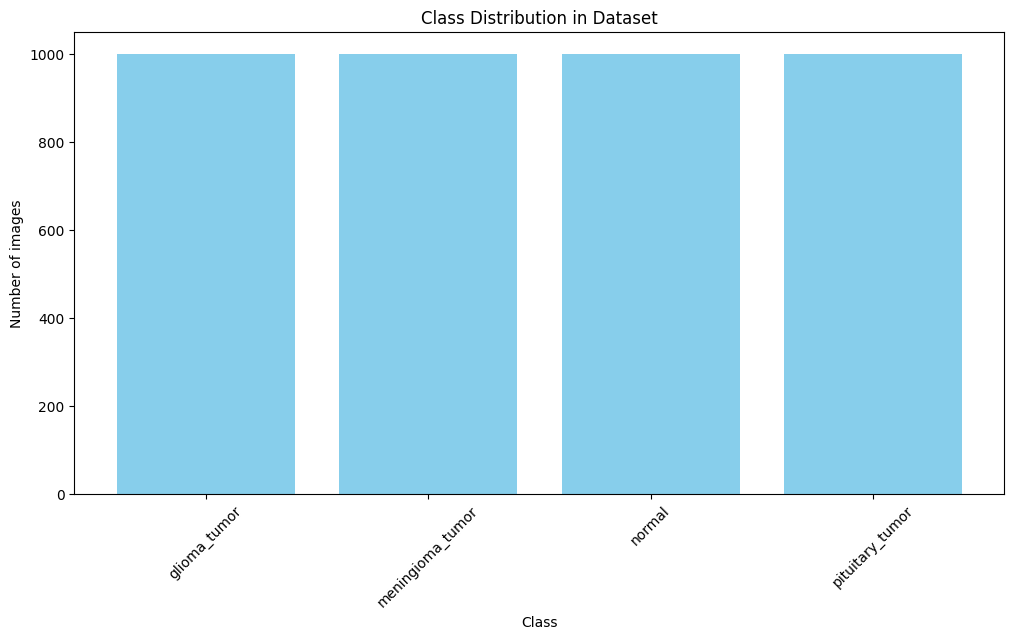

In [14]:
import matplotlib.pyplot as plt
from collections import Counter




classes = dataset.classes


class_count = Counter()


for _, label in dataset:
    class_count[label] += 1


labels = [classes[label] for label in class_count.keys()]
counts = [class_count[label] for label in class_count.keys()]


plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution in Dataset')
plt.xticks(rotation=45)
plt.show()




The shape of the input tensor is torch.Size([32, 3, 256, 256])


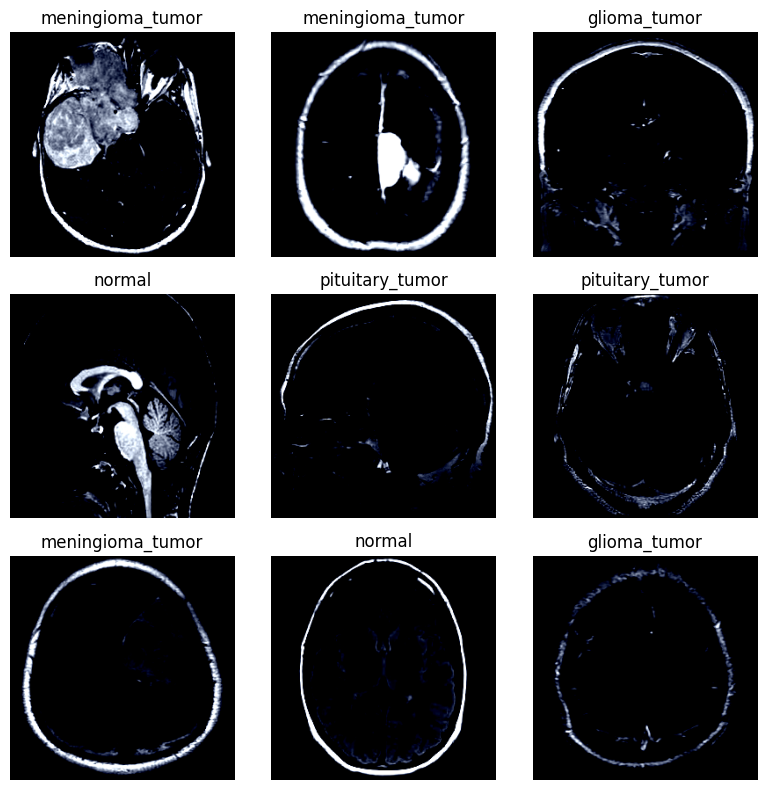

In [15]:


for X,y in iter(train_loader):
  fig, axes=plt.subplots(3,3, figsize=(8,8))

  classes=dataset.classes

  for i in range(9):
    img=X[i].numpy().transpose(1,2,0)

    ax= axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(classes[y[i].item()])
    ax.axis('off')
  print(f'\n\nThe shape of the input tensor is {X.shape}')
  plt.tight_layout()
  plt.show()
  break

# Building a model

## Fine tunning on VGG.


In [16]:
from torchvision import models
import torch.nn as nn
model_vgg= models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 131MB/s]


In [17]:
num_classes= len(dataset.classes)


In [18]:
'''model_vgg.classifier=nn.Sequential(
    nn.Linear(25088,256),
    nn.ReLU(True),
    nn.Dropout(p=0.35),
    nn.Linear(256,num_classes)
)'''

'model_vgg.classifier=nn.Sequential(\n    nn.Linear(25088,256),\n    nn.ReLU(True),\n    nn.Dropout(p=0.35),\n    nn.Linear(256,num_classes)\n)'

In [19]:
model_vgg.classifier=nn.Sequential(
    nn.Linear(25088,12544),
    nn.ReLU(True),
    nn.Dropout(p=0.35),
    nn.Linear(12544,6272),
    nn.ReLU(True),
    nn.Dropout(p=0.35),
    nn.Linear(6272,num_classes)
)

In [20]:
model_vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=12544, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.35, inplace=False)
  (3): Linear(in_features=12544, out_features=6272, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.35, inplace=False)
  (6): Linear(in_features=6272, out_features=4, bias=True)
)

### Loss function and Optimizer

In [21]:
#def freeze_base_layers(model):
  #for param in model.features.parameters():
    #param.requires_grad=False

In [22]:
#for param in model_vgg.classifier.parameters():
    #param.requires_grad = True

In [23]:
#freeze_base_layers(model_vgg)

In [24]:
for param in model_vgg.features[24:]:
    param.requires_grad = True

In [25]:
loss_fn=nn.CrossEntropyLoss()
#optimizer=torch.optim.Adam([p for p in model_vgg.parameters() if p.requires_grad], lr=0.01)
#optimizer=torch.optim.SGD(model_vgg.parameters(), lr=0.01)

In [26]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_vgg.parameters()), lr=0.001, momentum=0.9)


## Training the model

In [27]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00


In [28]:
from engine import train

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
model_vgg.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
!pip install torchinfo
import torchinfo
from torchinfo import summary
summary(model_vgg, [32,3,256,256])

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 4]                   --
├─Sequential: 1-1                        [32, 512, 8, 8]           --
│    └─Conv2d: 2-1                       [32, 64, 256, 256]        1,792
│    └─ReLU: 2-2                         [32, 64, 256, 256]        --
│    └─Conv2d: 2-3                       [32, 64, 256, 256]        36,928
│    └─ReLU: 2-4                         [32, 64, 256, 256]        --
│    └─MaxPool2d: 2-5                    [32, 64, 128, 128]        --
│    └─Conv2d: 2-6                       [32, 128, 128, 128]       73,856
│    └─ReLU: 2-7                         [32, 128, 128, 128]       --
│    └─Conv2d: 2-8                       [32, 128, 128, 128]       147,584
│    └─ReLU: 2-9                         [32, 128, 128, 128]       --
│    └─MaxPool2d: 2-10                   [32, 128, 64, 64]         --
│    └─Conv2d: 2-11                      [32, 256, 64, 64]         29

In [32]:
result=train(model=model_vgg,
             train_dataloader=train_loader,
             test_dataloader=val_loader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epochs=10,
             device=device)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 | train_loss: 0.7786 | train_acc: 0.6915 | test_loss: 0.4254 | test_acc: 0.8470
Epoch: 2 | train_loss: 0.2576 | train_acc: 0.9113 | test_loss: 0.4190 | test_acc: 0.8657
Epoch: 3 | train_loss: 0.1311 | train_acc: 0.9544 | test_loss: 0.2844 | test_acc: 0.8997
Epoch: 4 | train_loss: 0.0705 | train_acc: 0.9767 | test_loss: 0.2474 | test_acc: 0.9090
Epoch: 5 | train_loss: 0.0402 | train_acc: 0.9853 | test_loss: 0.2463 | test_acc: 0.9271
Epoch: 6 | train_loss: 0.0168 | train_acc: 0.9964 | test_loss: 0.2596 | test_acc: 0.9370
Epoch: 7 | train_loss: 0.0086 | train_acc: 0.9986 | test_loss: 0.2740 | test_acc: 0.9435
Epoch: 8 | train_loss: 0.0042 | train_acc: 0.9986 | test_loss: 0.2629 | test_acc: 0.9468
Epoch: 9 | train_loss: 0.0007 | train_acc: 1.0000 | test_loss: 0.2893 | test_acc: 0.9468
Epoch: 10 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 0.2942 | test_acc: 0.9419


test_acc,▁▂▅▅▇▇████
test_loss,██▂▁▁▂▂▂▃▃
train_acc,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
test_acc,0.94189
test_loss,0.29424
train_acc,1.0
train_loss,0.00029


In [33]:
from utils import save_model
save_model(model_vgg,target_dir='/content/models',model_name='Fine_tuned_VGG_1.pt')

[INFO] Saving model to: /content/models/Fine_tuned_VGG_1.pt


In [43]:
import torch
import torchvision
import matplotlib.pyplot as plt

from typing import List
import random

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

def pred_and_plot_random_image(
    model: torch.nn.Module,
    class_names: List[str],
    dataloader: torch.utils.data.DataLoader,
    device: torch.device = device,
):
    """Predicts and plots a random image from a DataLoader with its actual and predicted label.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on images.
        class_names (List[str]): A list of target classes to map predictions to.
        dataloader (torch.utils.data.DataLoader): DataLoader containing images to predict on.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Make sure the model is on the target device
    model.to(device)

    # Set model to evaluation mode
    model.eval()

    # Choose a random batch from the dataloader
    random_batch = random.choice(list(dataloader))
    images, labels = random_batch

    # Send images and labels to the target device
    images, labels = images.to(device), labels.to(device)

    # Make predictions on the batch of images
    with torch.inference_mode():
        preds = model(images)

    # Convert logits to prediction probabilities
    pred_probs = torch.softmax(preds, dim=1)

    # Convert prediction probabilities to predicted labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Choose a random index within the batch
    random_idx = random.randint(0, len(images) - 1)

    # Get the image, true label, and predicted label
    img = images[random_idx].cpu()  # Move to CPU for plotting
    true_label = class_names[labels[random_idx]]
    predicted_label = class_names[pred_labels[random_idx]]
    predicted_prob = pred_probs[random_idx].max().item()

    # Plot the image with actual and predicted labels
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))  # Rearrange dimensions for plotting
    plt.title(
        f"Actual: {true_label} | Pred: {predicted_label} | Prob: {predicted_prob:.3f}"
    )
    plt.axis(False)
    plt.show()


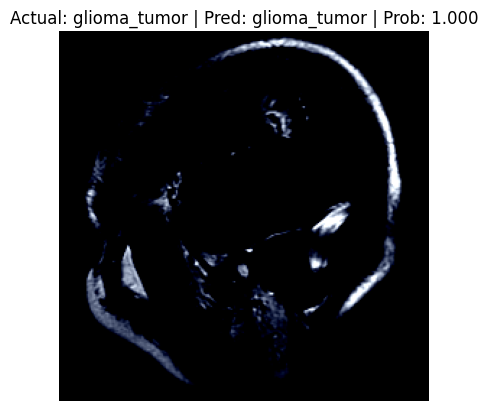

In [55]:
pred_and_plot_random_image(model_vgg,
                           dataset.classes,
                           test_loader,
                           device)